Author: Carlos Roberto

Date: 09/01/2020

Obj: Simular uma galáxia usando o MGE da ESO e um ML genérico que tentaremos recuperar depois com o Emcee.

In [1]:
import autolens as al
import autolens.plot as aplt
print("Pyautolens version:", al.__version__)

from pyprojroot import here
import numpy as np

from time import perf_counter as clock

from astropy.cosmology import Planck15 as cosmo
from astropy.constants import G, M_sun, c
import astropy.units as u

workspace_path = str(here())
print("Workspace Path: ", workspace_path)

Pyautolens version: 1.1.4
Workspace Path:  /home/carlos/autolens_workspace


In [2]:
#Lens parameters

z_lens = 0.035
z_source = 2.1

D_l = cosmo.angular_diameter_distance(z_lens)
D_s = cosmo.angular_diameter_distance(z_source)
D_ls = cosmo.angular_diameter_distance_z1z2(z_lens, z_source)

#Useful constants
metre2Mpc = (1*u.m).to(u.Mpc)/u.m           #Constant factor to convert metre to Mpc.
kg2Msun = (1*u.kg/M_sun)*u.solMass/u.kg     #Constant factor to convert kg to Msun

G_Mpc = G*(metre2Mpc)**3/kg2Msun            #Gravitational constant in Mpc³/(Msun s²)
c_Mpc = c*metre2Mpc                         #Speed of light in Mpc/s

In [3]:
#Data from MGE parametrization
surf_star_dat, sigma_star_dat, qstar_dat = np.loadtxt('/home/carlos/Desktop/Tests JAM- Emcee/JAM Input.txt', unpack=True) #Star
surf_DM_dat, sigma_DM_dat, qDM_dat = np.loadtxt('/home/carlos/Desktop/Tests JAM- Emcee/pseudo-DM Input.txt', unpack=True) #DM

In [4]:
#Convert  pot_DM_dat to total mass per Guassian

surf_DM_dat = surf_DM_dat*(u.solMass/u.pc**2)                                    #Surface Density in M_sun/pc²
sigma_DM_dat_ARC = sigma_DM_dat*u.arcsec                                         #Sigma in arcsec
sigma_DM_dat_PC = (sigma_DM_dat_ARC*D_l).to(u.pc, u.dimensionless_angles())      #Convert sigma in arcsec to sigma in pc
Mass_DM_dat = 2*np.pi*surf_DM_dat*(sigma_DM_dat_PC**2)*qDM_dat               #Total mass per gaussian component in M_sun

print("Total Mass per Gaussian component in DM profile:")
Mass_DM_dat

Total Mass per Gaussian component in DM profile:


<Quantity [1.23194867e-09, 6.68028441e-09, 3.58893618e-08, 1.89897869e-07,
           9.89900450e-07, 5.08804021e-06, 2.58197425e-05, 1.29571456e-04,
           6.44253580e-04, 3.18059614e-03, 1.56249060e-02, 7.65492253e-02,
           3.74810798e-01, 1.83785358e+00, 9.04115642e+00, 4.46886947e+01,
           2.22165111e+02, 1.11133428e+03, 5.59244260e+03, 2.82854563e+04,
           1.43578675e+05, 7.29981748e+05, 3.70825945e+06, 1.87705133e+07,
           9.44300607e+07, 4.74434743e+08, 2.54821917e+09, 1.97116739e+10,
           6.75514574e+11] solMass>

In [5]:
#Convert  surf_star_dat to total Luminosity per Guassian and then to total mass per gaussian

surf_star_dat = surf_star_dat*(u.solLum/u.pc**2)                                    #Surface luminosity Density in L_sun/pc²
sigma_star_dat_ARC = sigma_star_dat*u.arcsec                                        #Sigma in arcsec
sigma_star_dat_PC = (sigma_star_dat_ARC*D_l).to(u.pc, u.dimensionless_angles())     #Convert sigma in arcsec to sigma in pc
Lum_star_dat = 2*np.pi*surf_star_dat*(sigma_star_dat_PC**2)*qstar_dat               #Total luminosity per gaussian component in L_sun

print("Total Luminosity per Gaussian component of Stars:")
Lum_star_dat


Total Luminosity per Gaussian component of Stars:


<Quantity [3.95990609e+07, 2.14493871e+08, 2.59545468e+09, 5.99318897e+09,
           1.45617772e+10, 2.46067706e+10, 7.80698320e+10] solLum>

Now we will assume one mass-to-light (ML) ratio per component in Luminosity. This give us a total of 7-ML. We will use this values:

    ML = [9.5, 9.5, 8.5, 3.8, 3.4, 3.2, 2.8 ]

In [6]:
ML = np.array([9.5, 9.5, 8.5, 3.8, 3.4, 3.2, 2.8 ])*u.solMass/u.solLum      #Mass to light ratio per gaussian in M_sun/L_sun

Mass_star_dat = Lum_star_dat*ML                                             #Total star mass per gaussian in M_sun

print("Total Mass per Gaussian component of Star:")
Mass_star_dat

Total Mass per Gaussian component of Star:


<Quantity [3.76191079e+08, 2.03769178e+09, 2.20613647e+10, 2.27741181e+10,
           4.95100426e+10, 7.87416660e+10, 2.18595530e+11] solMass>

In [7]:
#Defining the general inputs for the model
i = np.deg2rad(85)*u.rad                                           #Inclination angle in rad
Total_Mass = np.append(Mass_star_dat, Mass_DM_dat)                 #Mass per gaussian component in M_sun
Total_q = np.append(qstar_dat, qDM_dat)                            #Total axial ratio per gaussian
Total_q_proj = np.sqrt(Total_q**2 - np.cos(i)**2)/np.sin(i)        #Total projected axial ratio per gaussian
Total_sigma_ARC = np.append(sigma_star_dat_ARC, sigma_DM_dat_ARC)  #Total sigma per gaussian in arcsec
Total_sigma_RAD = Total_sigma_ARC.to(u.rad)                        #Total sigma per gaussian in radians

print("Total Mass per Gaussian of Model:")
Total_Mass

Total Mass per Gaussian of Model:


<Quantity [3.76191079e+08, 2.03769178e+09, 2.20613647e+10, 2.27741181e+10,
           4.95100426e+10, 7.87416660e+10, 2.18595530e+11, 1.23194867e-09,
           6.68028441e-09, 3.58893618e-08, 1.89897869e-07, 9.89900450e-07,
           5.08804021e-06, 2.58197425e-05, 1.29571456e-04, 6.44253580e-04,
           3.18059614e-03, 1.56249060e-02, 7.65492253e-02, 3.74810798e-01,
           1.83785358e+00, 9.04115642e+00, 4.46886947e+01, 2.22165111e+02,
           1.11133428e+03, 5.59244260e+03, 2.82854563e+04, 1.43578675e+05,
           7.29981748e+05, 3.70825945e+06, 1.87705133e+07, 9.44300607e+07,
           4.74434743e+08, 2.54821917e+09, 1.97116739e+10, 6.75514574e+11] solMass>

__Defining the MGE mass model for the lens galaxy__

In [9]:
#Defing the grid
grid = al.Grid.uniform(shape_2d=(100, 100), pixel_scales=0.1, sub_size=1)
psf = al.Kernel.from_gaussian(shape_2d=(11, 11), sigma=0.1, pixel_scales=0.1)

In [43]:
%%time
#Iniciando o modelo MGE para a lente
time = clock()

mass_profile = al.mp.MGE(centre=(0.0, 0.0))                         #Definindo o modelo de massa
mass_profile.MGE_comps(M=Total_Mass.value, sigma=Total_sigma_RAD.value,
                       q=Total_q_proj.value, z_l=z_lens, z_s=z_source)        #Defindo os dados de entrada

mass_profile.MGE_Grid_parameters(grid)               #Criando a grid de parâmetros para o cálculo
                                                                         #em paralelo
#Criando o modelo da lente
lens_galaxy = al.Galaxy(                                            
        redshift=0.035,
        mass=mass_profile,
        shear=al.mp.ExternalShear(elliptical_comps=(0.02, -0.018)),
    )
print(lens_galaxy.shear)
print("Tempo para inicializar o modelo de lente MGE:", (clock() - time))

ExternalShear
centre: (0.0, 0.0)
elliptical_comps: (0.02, -0.018)
axis_ratio: 0.9475955629993166
phi: 65.99360624790833
magnitude: 0.02690724809414742
Tempo para inicializar o modelo de lente MGE: 0.6299728080011846
CPU times: user 631 ms, sys: 13 µs, total: 631 ms
Wall time: 630 ms


In [44]:
#Defining the source model

source_galaxy = al.Galaxy(
    redshift=2.1,
    light= al.lp.SphericalSersic(
                    centre=(0.0, 0.0), 
                    intensity=1.0, 
                    effective_radius=0.5, 
                    sersic_index=1.0
        ),
)
    


print(source_galaxy)

Redshift: 2.1
Light Profiles:
SphericalSersic
centre: (0.0, 0.0)
elliptical_comps: (0.0, 0.0)
axis_ratio: 1.0
phi: 0.0
intensity: 1.0
effective_radius: 0.5
sersic_index: 1.0


In [45]:
#Ray tracing the source galaxy and mask
tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, source_galaxy])
lens_galaxy.shear

ExternalShear
centre: (0.0, 0.0)
elliptical_comps: (0.02, -0.018)
axis_ratio: 0.9475955629993166
phi: 65.99360624790833
magnitude: 0.02690724809414742

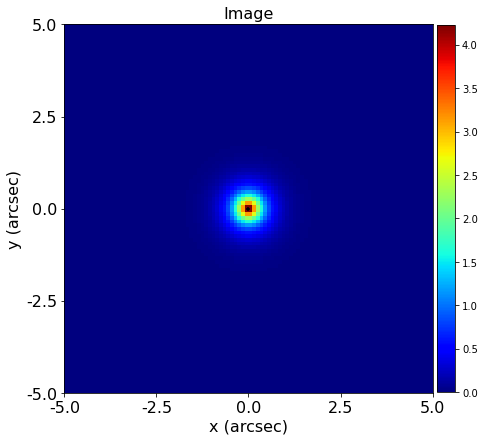

In [46]:
#Save image of source galaxy and plot it
plotter = aplt.Plotter(
    output=aplt.Output(path='/home/carlos/autolens_workspace/Gaussian Emcee/Images/',
                       filename='Source Galaxy',
                       format='png'),
    labels=aplt.Labels(title='Source Galaxy'),             
)

aplt.Galaxy.image(galaxy=source_galaxy, grid=grid, 
                  plotter=plotter)
aplt.Galaxy.image(galaxy=source_galaxy, grid=grid)


Critical curve could not be calculated due to an unphysical mass model
Critical curve could not be calculated due to an unphysical mass model


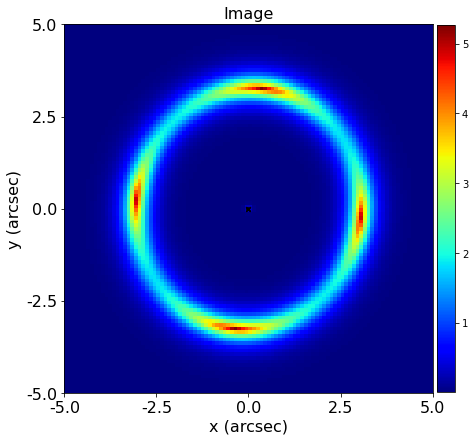

Tempo ray tracing numa grid de 10000 pontos: 24.287332 


In [47]:
#Finaly we can perform the tracinng and plot the arcs
#Save image of arcs and plot it

plotter = aplt.Plotter(
    output=aplt.Output(path='/home/carlos/autolens_workspace/Gaussian Emcee/Images/',
                       filename='Arcs',
                       format='png'),
    labels=aplt.Labels(title='Arcs'),             
                      )
aplt.Tracer.image(tracer=tracer, grid=grid, plotter=plotter)

time = clock()
aplt.Tracer.image(tracer=tracer, grid=grid)
print("Tempo ray tracing numa grid de %i pontos: %f " %(grid.shape[0], clock()- time))

In [48]:
%%time
#Simulating the arcs image: Add Noise and PSF

simulator = al.SimulatorImaging(
    exposure_time_map=al.Array.full(fill_value=300.0, shape_2d=grid.shape_2d),
    psf=psf,
    background_sky_map=al.Array.full(fill_value=0.1, shape_2d=grid.shape_2d),
    add_noise=True,
)

imaging = simulator.from_tracer_and_grid(tracer=tracer, grid=grid)

CPU times: user 32.3 s, sys: 3.93 ms, total: 32.3 s
Wall time: 32.4 s


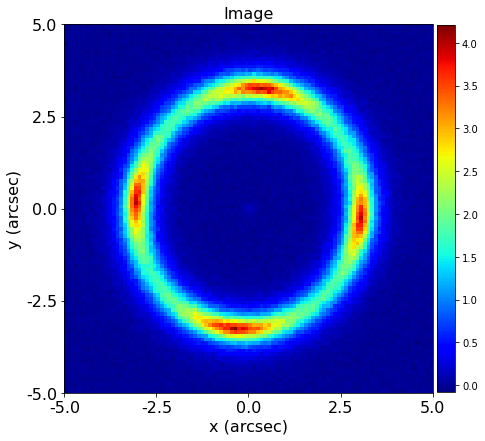

In [49]:
#Plot simulated image and save it
plotter = aplt.Plotter(output=aplt.Output(path='/home/carlos/autolens_workspace/Gaussian Emcee/Images/',
                                          filename='Simulated Arcs',
                                           format='png'),
                       labels=aplt.Labels(title='Arcs with Noise and PSF'),             
                      )
aplt.Imaging.image(imaging=imaging, plotter=plotter)
aplt.Imaging.image(imaging=imaging)

In [50]:
#Finaly we save the result
from pyprojroot import here

workspace_path = str(here())
dataset_path = f"{workspace_path}/Gaussian Emcee/Data"
print("Dataset Path: ", dataset_path)

Dataset Path:  /home/carlos/autolens_workspace/Gaussian Emcee/Data


In [51]:
#Save the simulated image in .fits file
imaging.output_to_fits(
    image_path=f"{dataset_path}/Image.fits",
    noise_map_path=f"{dataset_path}/Noise.fits",
    psf_path=f"{dataset_path}/PSF.fits",
    overwrite=True,
)